<a href="https://colab.research.google.com/github/leawt/tier2023/blob/main/topicModeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INSTRUCTIONS

**Running Search**
1.   Connect to a runtime (click button next to pen icon on top right)
2.   Open the left-hand side 'folder' tab
3.   If the folder 'tier2022' does not exist, run the SET UP section.
4.   Run the CORDIS Database Keyword Search code section
5.   If you have not yet downloaded reportStyle.css, download it.
6.   Download html_report.html by right-click -> download.
7.   Download keywordResults.xlsx by double-clicking it.
8.   To do another search, just run the CORDIS Database Keyword Search part.

**Running Topic Modeling**

# SET UP

Run this portion if the 'files' tab on the left does not contain the folder '*tier2022*'

In [10]:
!git clone https://github.com/kaikato/tier2022.git /content/tier2022
%cd /content/tier2022
!pip install xlsxwriter --quiet
!pip install pyLDAvis==2.1.2 --quiet
!pip install nltk

Cloning into '/content/tier2022'...
remote: Enumerating objects: 170, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 170 (delta 7), reused 15 (delta 3), pack-reused 151
Receiving objects: 100% (170/170), 211.02 MiB | 21.51 MiB/s, done.
Resolving deltas: 100% (67/67), done.
/content/tier2022
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done



# CORDIS Database Keyword Search



In [100]:
import numpy as np
import pandas as pd
import openpyxl
import os
import plotly.graph_objects as go
import json
import xlsxwriter
import plotly.express as px
pd.options.mode.chained_assignment = None

includeUkri = False
includeCordis = False
isUnion = True
isDateFilter = False
# Take user input for the keyword to be searched.
print('Welcome to keyword search.')
print('Datasets available: CORDIS, UKRI')
dataUKRI = input("Would you like to search through UKRI data? (y/n): ").lower()
if dataUKRI == 'y':
  includeUkri = True
dataCordis = input("Would you like to search through CORDIS data? (y/n): ").lower()
if dataCordis == 'y':
  includeCordis = True

print(' ')

filterDate = input("Would you like to filter by date? (y/n): ").lower()
if filterDate == 'y':
  isDateFilter = True
  print("Ok!")
  startDate = input("Enter a start date in the format YYYY-MM-DD or YYYY: ")
  endDate = input("Enter an end date in the format YYYY-MM-DD or YYYY: ")
print(' ')
print("---------------------------")
print('Default search mode will look for keyword1 OR keyword2.')
keywordList = []
keyword = input('Enter first keyword, or enter 1 if you want to change mode to AND search: ')
print("---------------------------")
if keyword == '1':
  isUnion = False
  print('You are now doing a search based on keyword1 AND keyword2...')
while keyword != "":
  if keyword != '1':
    keywordList.append(keyword.lower())
    keyword = input('Enter next keyword (enter nothing if done): ')
  else:
    keyword = input('Enter first keyword: ')
print("---------------------------")
print("Searching for keyword(s)...")

def convertDTypes(df, lst):
  for label in lst:
    df[label] = df[label].str.strip()
    df[label] = df[label].str.replace(',', '')
    df[label] = pd.to_numeric(df[label], errors='coerce')
  return df

def readFiles(val1, val2):
  li = []
  if val1: # CORDIS
    cordis = pd.read_csv("/content/tier2022/data/csv/project.csv", delimiter=";")
    li.append(cordis)
  if val2: # ADJUST VALUE HERE FOR GIT TO BE UPDATED
    ukri = pd.read_csv("/content/tier2022/data/csv/InnovateUKFundedProjects.csv", on_bad_lines='skip')
    ukri.rename(columns={'Project Number':'id','Project Status':'status','Project Title':'title','Project Start Date':'startDate','Project End Date':'endDate',' Award Offered (£) ':'ecMaxContribution', ' Total Costs (£) ':'totalCost',
                            'Programme Title':'legalBasis','Sector':'topics','Public Description':'objective', 'Is Lead Participant':'role'}, inplace=True)
    ukri = convertDTypes(ukri, ['totalCost', 'ecMaxContribution'])
    ukri['role'] = ukri['role'].str.replace('Yes', 'coordinator')
    ukri['role'] = ukri['role'].str.replace('No', 'participant')
    ukri['acronym'] = ukri['title']
    ukri['startDate'] = pd.to_datetime(ukri['startDate'], format='%m/%d/%y').dt.strftime('%Y-%m-%d')
    ukri['endDate'] = pd.to_datetime(ukri['endDate'], format='%m/%d/%y').dt.strftime('%Y-%m-%d')
    li.append(ukri)
  return pd.concat(li, join='outer')

if not keywordList:
  print("No keywords given")
else:
  projects = readFiles(includeCordis, includeUkri)
  # projects = convertDTypes(projects, ['ecMaxContribution', 'totalCost'])

  if isDateFilter:
    projects['startDate'] = pd.to_datetime(projects['startDate'])
    projects['endDate'] = pd.to_datetime(projects['endDate'])
    startDate = pd.to_datetime(startDate)
    endDate = pd.to_datetime(endDate)
    # filter
    projects = projects[(projects['startDate'] >= startDate) & (projects['endDate'] <= endDate)]
    # convert back to strings
    projects['startDate'] = pd.to_datetime(projects['startDate']).dt.strftime('%Y-%m-%d')
    projects['endDate'] = pd.to_datetime(projects['endDate']).dt.strftime('%Y-%m-%d')

  useDF = projects
  if not isUnion:
    #drops all the rows where one of the keywords don't exist.
    for key in keywordList:
      useDF = useDF[~(~useDF['objective'].str.contains(key, na=False) & ~useDF['title'].str.contains(key, na=False))]

  objectives = pd.Series(useDF['objective'], dtype="string").str.lower()
  titles = pd.Series(useDF['title'], dtype="string").str.lower()

  #counts the number of keyword occurences.
  counts = objectives.str.count(r'(?<!\w)(' + keywordList[0] + ')(?!\w)') + titles.str.count(r'(?<!\w)(' + keywordList[0] + ')(?!\w)')
  for key in keywordList[1:]:
    counts = counts + objectives.str.count(r'(?<!\w)(' + key + ')(?!\w)') + titles.str.count(r'(?<!\w)(' + key + ')(?!\w)')
  counts = counts[counts>0]
  if counts.size == 0 and keywordList[0] != '(all)':
    print("Keyword(s) not found")
  else:
    sortedCounts = counts.sort_values(ascending=False)
    if keywordList[0] == '(all)':
      print('Searching through all projects.')
      projectList = projects[['id', 'acronym', 'title', 'startDate', 'endDate', 'totalCost', 'ecMaxContribution', 'legalBasis', 'fundingScheme', 'objective']]
    else:
      projectList = projects.loc[sortedCounts.index][['id', 'acronym', 'title', 'startDate', 'endDate', 'totalCost', 'ecMaxContribution', 'legalBasis', 'objective']]
      # projectList['keywordCounts'] = sortedCounts.drop_duplicates()
    projectList = projectList.drop_duplicates(subset=['id'])
    if projectList['totalCost'].dtype.str == 'object':
      projectList = convertDTypes(projectList, ['totalCost', 'ecMaxContribution'])
    # projectList['percentEUFunded'] = (projectList['ecMaxContribution']/projectList['totalCost']).apply(lambda x: f"{x:.0%}")
    print(str(len(projectList.index)) + ' projects found')

    # creates the company(organizations) slices
    li = []
    cols = ['name', 'acronym', 'shortName', 'country', 'totalCost', 'ecContribution', 'netEcContribution', 'projectID', 'role']
    if includeCordis:
      org = pd.read_csv("/content/tier2022/data/csv/organization.csv", delimiter=";", usecols = ['name', 'projectAcronym', 'shortName', 'country', 'ecContribution', 'netEcContribution', 'totalCost', 'projectID', 'role'])
      org.rename(columns={'projectAcronym':'acronym'}, inplace=True)
      org = convertDTypes(org, ['totalCost'])
      li.append(org)
    if includeUkri:
      org = readFiles(False,True)
      org.rename(columns={'id':'projectID', 'Participant Name':'name'}, inplace=True)
      org['country'] = np.where(org['Address Region'] == 'Outside UK', np.NaN, 'UK')
      org['shortName'] = ''
      # change currency from pounds to euro
      org['date'] = pd.to_datetime(org['startDate'])
      org['quarter'] = org['date'].dt.to_period('Q').astype('str')
      temp = pd.read_csv('/content/tier2022/data/exchangeRateData.csv', usecols=[0,1], skiprows=[i for i in range(6)], header=None, on_bad_lines='skip')
      exchange = dict(zip(temp[0], temp[1].astype('float')))
      org['exchange'] = org['quarter'].map(exchange)
      org['totalCost'] = org['totalCost'] * org['exchange']
      org['ecContribution'] = org['ecMaxContribution'] * org['exchange']
      org['netEcContribution'] = np.NaN
      org = org[org.columns.intersection(cols)]
      li.append(org)
    orgs = pd.concat(li)

    t = orgs[orgs['projectID'].isin(projectList['id'])]
    companyList = t[cols]
    companyList = companyList.sort_values(by=['name'])
    uk_subset = companyList[companyList['country'] == 'UK']
    non_uk_subset = companyList[companyList['country'] != 'UK']
    tt = non_uk_subset.groupby('projectID')[['totalCost', 'ecContribution']].sum(numeric_only=True)
    ttt = uk_subset.groupby('projectID')[['totalCost', 'ecContribution']].sum(numeric_only=True)
    projectList['totalCost'] = projectList['id'].map(companyList.groupby('projectID')[['totalCost', 'ecContribution']].sum()['totalCost'])
    projectList['ecMaxContribution'] = projectList['id'].map(tt['ecContribution'])
    projectList['UKContribution'] = projectList['id'].map(ttt['ecContribution'])
    projectList['ecMaxContribution'].fillna(0, inplace=True)
    projectList['UKContribution'].fillna(0, inplace=True)
    topRelevanceProjects = projectList.head()
    topCostProjects = projectList.sort_values(by=['totalCost'],ascending=False).head()

    def generate_counts_df(df):
      countsDF = df['name'].value_counts().to_frame().reset_index(level=0)
      countsDF.columns = ['name', 'nProjects']
      countsDF = countsDF.merge(df.drop_duplicates(subset=['name']), how="left", on='name')
      countsDF = countsDF.drop(['totalCost','projectID', 'role'], axis=1)
      countsDF = countsDF.iloc[:,[0,2,3,1]]
      return countsDF

    def generate_costs_df(df1, df2):
      costDF = df1.groupby(['name']).sum(numeric_only=True)
      costDF = costDF.sort_values(by='totalCost',ascending=False)
      costDF = costDF.reset_index(level=0)
      costDF = costDF.drop(['projectID', 'ecContribution', 'netEcContribution'], axis=1)
      costDF = costDF.merge(df1.drop_duplicates(subset=['name']), how="left", on='name')
      costDF = costDF.merge(df2[['name','nProjects']], how='left', on='name')
      costDF = costDF.drop(['totalCost_y','projectID', 'role'], axis=1)
      return costDF

    # coordinatorCounts is the 'organisation' database filtered for coordinators and ranked by # of projects
    coordinatorList = companyList[companyList['role']=="coordinator"]
    coordinatorCounts = generate_counts_df(coordinatorList)

    # allCounts is the 'organisation' database with all coordinators + participants and ranked by # of projects
    allCounts = generate_counts_df(companyList)
    allCounts = allCounts.merge(coordinatorCounts[['name', 'nProjects']], how='left', on='name')
    allCounts.rename(columns = {'nProjects_x': 'nProjects', 'nProjects_y':'Number of Projects Coordinated'}, inplace=True)
    allCounts.fillna(0, inplace=True)
    allCounts['Number of Projects Coordinated'] = allCounts['Number of Projects Coordinated'].apply(lambda x: f"{x:.0f}")

    sumCost = projectList['totalCost'].sum()
    sumEC = projectList['ecMaxContribution'].sum()
    sumUK = projectList['UKContribution'].sum()

    labels = ['EC Max Contribution', 'UKRI Contribution', 'Other Contribution']
    values = [sumEC, sumUK, sumCost-sumEC-sumUK]
    figCosts = go.Figure(data=[go.Pie(labels=labels, values=values)], layout=go.Layout(
            title=go.layout.Title(text="EU Contributions Relative to Other Contributions")
        ))

    sumCost = "{:,.0f}".format(sumCost)
    sumEC = "{:,.0f}".format(sumEC)
    sumUK = "{:,.0f}".format(sumUK)

    # coordinatorCosts is the organisations database filtered for coordinators and ranked by total costs
    coordinatorCosts = generate_costs_df(coordinatorList, coordinatorCounts)

    # allCosts is the organisations database sorted by total costs for each org
    allCosts = generate_costs_df(companyList, allCounts)
    allCosts = allCosts.merge(coordinatorCosts[['name', 'nProjects']], how='left', on='name')
    allCosts.rename(columns = {'nProjects_x': 'nProjects', 'nProjects_y':'Number of Projects Coordinated'}, inplace=True)
    allCosts.fillna(0, inplace=True)
    allCosts['Number of Projects Coordinated'] = allCosts['Number of Projects Coordinated'].apply(lambda x: f"{x:.0f}")
    companyList = companyList.merge(projectList['id'], how='left', left_on='projectID', right_on='id')
    companyList.drop(labels='id', axis=1, inplace=True)

    # writes results into the keywordResults.xlsx spreadsheet
    with pd.ExcelWriter("keywordResults.xlsx", engine='xlsxwriter') as writer:
        projectList.to_excel(writer, sheet_name="projects", index=False, float_format="%f")
        companyList.to_excel(writer, sheet_name="organizations", index=False, float_format="%f")
        coordinatorCounts.to_excel(writer, sheet_name='nProjects (coordinators)', index=False)
        allCounts.to_excel(writer, sheet_name='nProjects (all)', index=False)
        coordinatorCosts.to_excel(writer, sheet_name='by cost (coordinators)', index=False)
        allCosts.to_excel(writer, sheet_name='by cost (all)', index=False)

    # generate graphs
    topRelevanceProjects['otherContribution'] = topRelevanceProjects['totalCost']-topRelevanceProjects['ecMaxContribution']-topRelevanceProjects['UKContribution']
    topCostProjects['otherContribution'] = topCostProjects['totalCost']-topCostProjects['ecMaxContribution']-topCostProjects['UKContribution']
    relevantProjectCounts = px.bar(topRelevanceProjects, title="Most Relevant Projects", x='acronym', y=[topRelevanceProjects['ecMaxContribution'],topRelevanceProjects['UKContribution'], topRelevanceProjects['otherContribution']], labels={"acronym":"Organization", "value":"Total Cost (Euro)"})
    costlyProjectCounts = px.bar(topCostProjects, title="Most Costly Projects", x='acronym', y=[topCostProjects['ecMaxContribution'],topCostProjects['UKContribution'],topCostProjects['otherContribution']], labels={"acronym":"Organization", "value":"Total Cost (Euro)"})
    coordinatorCountsGraph = px.bar(coordinatorCounts.head(), title="Coordinator No. of Projects", x='shortName', y='nProjects', labels={'shortName':'Organization','nProjects':'Number of Projects'})
    coordinatorCountsGraph.update_traces(marker_color='green')
    allCountsGraph = px.bar(allCounts.head(), title="All Companies No. of Projects", x='shortName', y='nProjects', labels={'shortName':'Organization','nProjects':'Number of Projects'})
    coordinatorCostsGraph = px.bar(coordinatorCosts.head(), title="Coordinator Total Cost of Projects", x='shortName', y='totalCost_x', text='nProjects', labels={'shortName':'Organization','totalCost_x':'Total Cost of Projects'})
    coordinatorCostsGraph.update_traces(marker_color='green')
    allCostsGraph = px.bar(allCosts.head(), title="All Companies Total Cost of Projects", x='shortName', y='totalCost_x', text='nProjects', labels={'shortName':'Organization','totalCost_x':'Total Cost of Projects'})

    def reformat_projects(df):
      df['totalCost'] = df['totalCost'].apply(lambda x: f"{x:,.0f}")
      if len(df['id'].astype(str)) < 9:
        df['id'] = df['id'].apply(lambda x: f'<a href="https://gtr.ukri.org/projects?ref={x}">{x}</a>')
      else:
        df['id'] = df['id'].apply(lambda x: f'<a href="https://cordis.europa.eu/project/id/{x}">{x}</a>')
      df.rename(columns = {'id':'ID', 'acronym':'Short Title', 'title': 'Project Title', 'totalCost':'Total Cost (Euro)', 'percentEUFunded': 'EU Funding Ratio', 'startDate':'Start Date', 'endDate':'End Date'}, inplace = True)
      return df

    # format dataframes for html report
    topRelevanceProjects = reformat_projects(topRelevanceProjects)
    topCostProjects = reformat_projects(topCostProjects)
    coordinatorCounts.rename(columns = {'name': 'Coordinator Name', 'nProjects': 'Number of Projects Coordinated', 'shortName': 'Short Name', 'country':'Country'}, inplace = True)
    allCounts.rename(columns = {'name': 'Organisation Name', 'nProjects': 'Number of Projects Involved', 'nProjects_y': 'Number of Projects Coordinated', 'shortName': 'Short Name', 'country':'Country'}, inplace = True)
    coordinatorCosts['totalCost_x'] = coordinatorCosts['totalCost_x'].apply(lambda x: f"{x:,.0f}")
    coordinatorCosts.rename(columns = {'name': 'Coordinator Name', 'nProjects': 'Number of Projects Coordinated', 'shortName': 'Short Name', 'country':'Country', 'totalCost_x':'Total  (Euro)'}, inplace = True)
    coordinatorCosts.drop(['ecContribution', 'netEcContribution'], axis=1, inplace=True)
    allCosts['totalCost_x'] = allCosts['totalCost_x'].apply(lambda x: f"{x:,.0f}")
    allCosts.rename(columns = {'name': 'Organisation Name', 'nProjects': 'Number of Projects Involved', 'nProjects_y':'Number of Projects Coordinated','shortName': 'Short Name', 'country':'Country', 'totalCost_x':'Total Cost (Euro)'}, inplace = True)
    allCosts.drop(['ecContribution', 'netEcContribution'], axis=1, inplace=True)

    # Creates html report
    page_title = "Keyword Report"
    if not includeUkri & includeCordis :
      source = "' in CORDIS Horizon"
    elif not includeCordis & includeUkri:
      source = "' in UKRI"
    elif includeCordis & includeUkri:
      source = "' in CORDIS and UKRI"

    if isUnion:
      title_text="Results for '" + " OR ".join(keywordList) + source
    else:
      title_text="Results for '" + " AND ".join(keywordList) + source

    #text stubs for the report.
    text="Total number of results: " + str(len(projectList.index))
    projects_text='Most relevant projects by frequency of keyword(s)'
    projects_subtitle='These projects used the keywords most frequently in their title and objective statements.'
    projects_text_cost='Most costly projects with keyword(s)'
    projects_text_cost_subtitle='These projects were the most costly out of the projects that contained the keyword(s).'
    total_text='Total cost of all projects: &euro;'
    ec_text='Max contributions by the EC: &euro;'
    uk_text='Max contributions by the UK: &euro;'
    keywords_text ='Other prominent keywords from the selected projects'
    commonCompanies_text = 'Most involved companies by number of projects with keyword(s)'
    costlyCompanies_text = 'Most involved companies by total cost of projects with keyword(s)'
    coordinatorCounts_subtext = 'Full data can be found in the "nProject (coordinators)" sheet.'
    allCounts_subtext = 'Full data can be found in the "nProject (all)" sheet.'
    coordinatorCosts_subtext = 'Full data can be found in the "by cost (coordinators)" sheet.'
    allCosts_subtext = 'Full data can be found in the "by cost (all)" sheet.'

    html = f'''
        <html>
          <head>
              <title>{page_title}</title>
              <link rel="stylesheet" href="reportStyle.css" type="text/css" media="all">
              <meta charset="UTF-8">
              <script src="https://cdn.plot.ly/plotly-2.12.1.min.js"></script>
          </head>
          <body>
            <div id="title">
              <h1>{title_text}</h1>
                <p>{text}</p>
            </div>
            <div id="topRelevance">
              <h2>{projects_text}</h2>
                <p>{projects_subtitle}</p>
                {topRelevanceProjects.to_html(index=False, escape=False, justify="center", classes='table', table_id="topProjects", columns=['ID', 'Short Title', 'Project Title', 'Start Date', 'End Date', 'Total Cost (Euro)'])}
                {relevantProjectCounts.to_html(full_html=False, include_plotlyjs=False, default_width='50%', default_height='65%', div_id='relevantProjGraph')}
            </div>
            <div id="topCost">
              <h2>{projects_text_cost}</h2>
                <p>{projects_text_cost_subtitle}</p>
                {topCostProjects.to_html(index=False, escape=False, justify="center", classes='table', table_id="costProjects", columns=['ID', 'Short Title', 'Project Title',  'Start Date', 'End Date', 'Total Cost (Euro)'])}
                {costlyProjectCounts.to_html(full_html=False, include_plotlyjs=False, default_width='50%', default_height='65%', div_id='costProjGraph')}
            </div>
            <div id ="parent" class="clearfix">
              <div id="cost">
                <h2>{total_text}{sumCost}</h2>
                <h2>{ec_text}{sumEC}</h2>
                <h2>{uk_text}{sumUK}</h2>
                {figCosts.to_html(full_html=False, include_plotlyjs=False, default_width='70%', default_height='65%', div_id='costsPieGraph')}
              </div>
            </div>
            <div id="commonCompanies">
              <h2>{commonCompanies_text}</h2>
                <h3>As Coordinators</h3>
                  {coordinatorCounts.head(5).to_html(index=False, justify="center", classes='table', table_id='coordinatorCounts')}
                  <p class="referText">{coordinatorCounts_subtext}</p>
                  {coordinatorCountsGraph.to_html(full_html=False, include_plotlyjs=False, default_width='50%', default_height='65%', div_id='coordinatorCountsGraph')}

                <h3>Coordinators & Participants</h3>
                  {allCounts.head(5).to_html(index=False, justify="center", classes='table', table_id='allCounts')}
                  <p class="referText">{allCounts_subtext}</p>
                  {allCountsGraph.to_html(full_html=False, include_plotlyjs=False, default_width='50%', default_height='65%', div_id='allCountsGraph')}

            </div>
            <div id="companyCosts">
              <h2>{costlyCompanies_text}</h2>
                <div id="coordinatorCostsContainer">
                  <h3>As Coordinators</h3>
                    {coordinatorCosts.head().to_html(index=False, justify="center", classes='table', table_id='coordinatorCosts')}
                    <p class="referText">{coordinatorCosts_subtext}</p>
                    {coordinatorCostsGraph.to_html(full_html=False, include_plotlyjs=False, default_width='50%', default_height='65%', div_id='coordinatorCostsGraph')}
                </div>
                <div id="allCostsContainer">
                  <h3>Coordinators & Participants</h3>
                  {allCosts.head().to_html(index=False, justify="center", classes='table', table_id='allCosts')}
                  <p class="referText">{allCosts_subtext}</p>
                  {allCostsGraph.to_html(full_html=False, include_plotlyjs=False, default_width='50%', default_height='65%', div_id='allCostsGraph')}
                </div>
            </div>
          </body>
        </html>
      '''

with open('html_report.html', 'w') as f:
    f.write(html)

print("All done!")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

<>:103: DeprecationWarning:

invalid escape sequence '\w'

<>:103: DeprecationWarning:

invalid escape sequence '\w'

<>:105: DeprecationWarning:

invalid escape sequence '\w'

<>:105: DeprecationWarning:

invalid escape sequence '\w'

<>:103: DeprecationWarning:

invalid escape sequence '\w'

<>:103: DeprecationWarning:

invalid escape sequence '\w'

<>:105: DeprecationWarning:

invalid escape sequence '\w'

<>:105: DeprecationWarning:

invalid escape sequence '\w'

<ipython-input-100-c7f44fb8814d>:103: DeprecationWarning:

invalid escape sequence '\w'

<ipython-input-100-c7f44fb8814d>:103: DeprecationWarning:

invalid escape sequence '\w'

<ipython-input-100-c7f

Welcome to keyword search.
Datasets available: CORDIS, UKRI
Would you like to search through UKRI data? (y/n): y
Would you like to search through CORDIS data? (y/n): y
 
Would you like to filter by date? (y/n): n
 
---------------------------
Default search mode will look for keyword1 OR keyword2.
Enter first keyword, or enter 1 if you want to change mode to AND search: energy
---------------------------
Enter next keyword (enter nothing if done): 
---------------------------
Searching for keyword(s)...
7196 projects found
All done!


**A note about search terms** \\
The search is not case-sensitive. Searching for 'Net Zero' will result in hits for 'NET ZERO', 'net zero', and 'Net zero'. \\
The search will only match your keywords surrounded by punctuation. If other letters are connected to your search term(s), those words will not result in hits. For example, if you search for 'bus', it will not return 'business' or 'busy'. \\
The OR search returns all projects that contain at least one instance of any of the search terms. \\
The AND search will not return projects that do not contain at least one instance of each search term.

# Topic Modeling

### Loading Data and Pre-processing

The following cells load the data (search results) and edits the data such that it can be used to train the model.

Tehcnical aspects:
- Project titles and descriptions are turned into a list of words
- Each word is converted to their root word form (ie. researched turns into research)
- Unnecessary words (aka stop words) are removed
- Each word is then converted to a unique numerical value

In [101]:
%%capture
import re
import nltk
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import FreqDist
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
import gensim
from gensim.models.coherencemodel import CoherenceModel
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from pprint import pprint

# Data loaded
df = pd.read_excel('/content/tier2022/keywordResults.xlsx')
df = df.fillna('')
df = df.fillna('-')

def preprocess_text(text):
    text = text.replace('_', ' ')
    # Convert text to lowercase
    text = text.lower()
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize the text
    tokens = word_tokenize(text)
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Add bi-grams
    bigrams = list(nltk.bigrams(tokens))[:20]
    tokens += ['_'.join(bigram) for bigram in bigrams]
    return tokens

# Apply text preprocessing and stemming
df = df.drop_duplicates(subset=['objective'])
df['text'] = df['objective'] + " " + df['title']
preprocessed_text = df['text'].apply(preprocess_text)
df['preprocessed_text'] = preprocessed_text

all_tokens = [token for tokens in preprocessed_text for token in tokens] # Calculate word frequencies
word_freq = FreqDist(all_tokens)
num_common_words = 50 # Set the number of common words to consider as stop words
common_words = [word for word, freq in word_freq.most_common(num_common_words)]
stop_words = set(stopwords.words('english')).union(common_words) # creates preliminary stopword list

# ↓ ↓ ↓ ↓ ↓ If you want to add any specific words to take out of the program add them here, see domain_specific_words for formatting ↓ ↓ ↓ ↓ ↓
specific_words = [] # INSERT HERE AND ERASE WHEN DONE
domain_specific_words = ['the', 'design', 'and', 'of', 'to', 'a', 'in', 'for', 'will', 'is', 'with', 'this', 'be', 'project', 'that', 'by', 'on', 'are', 'technology',
                         'system', 'an', 'it', 'from', 'uk', 'can', 'new', 'which', 'at', 'we', 'ha', 'develop', 'data', 'their', 'have', 'cost', 'process',
                         'use', 'development', 'product', 'our', 'these', 'or', 'market', 'design', 'solution', 'through', 'high', 'material', 'industry', 'more', 'using', 'application', 'such', 'need', 'research',
                         'university', 'into', 'service', 'also', 'not', 'production', 'manufacturing', 'provide', 'public', 'novel', 'aim', 'innovative', 'platform', 'vehicle', 'used', 'based', 'time', 'power', 'support', 'patient',
                         'potential', 'enable', 'been', 'business', 'approach', 'performance', 'model', 'supply', 'other', 'impact', 'but', 'developed', 'all', 'sector', 'cell', 'they', 'key', 'tool', 'health', 'device', 'reduce', 'within',
                         'limited', 'current', 'innovation', 'digital', 'low', 'benefit', 'control', 'work', 'management', 'company', 'existing', 'network', 'test', 'study', 'user', 'improve', 'there', 'both', 'commercial',
                         'over', 'chain', 'waste', 'method', 'challenge', 'quality', 'including', 'future', 'significant', 'year', 'developing', 'up', 'range', 'across', 'battery', 'change', 'component', 'level', 'deliver',
                         'partner', 'help', 'one', 'advanced', 'food', 'increase', 'capability', 'global', 'value', 'opportunity', 'between', 'sustainable', 'efficiency', 'information', 'building', 'disease', 'people', 'most', 'industrial', 'well',
                         'risk', 'than', 'create', 'how', 'result', 'life', 'no', 'currently', 'world', 'however', 'infrastructure', 'make', 'first', 'area', 'treatment', 'sensor', 'large', 'many', 'monitoring', 'where', 'integrated', 'leading', 'way',
                         'allow', 'generation', 'part', 'access', 'address', 'fuel', 'technique', 'scale', 'local', 'analysis', 'feasibility', 'demand', 'build', 'summary', 'would', 'them', 'operation', 'european', 'eu']
stop_words.update(domain_specific_words)
stop_words.update(specific_words)

# Apply the stop word list and join the tokens back to text
preprocessed_text = preprocessed_text.apply(lambda tokens: ' '.join([token for token in tokens if token not in stop_words]))

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data = preprocessed_text.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
print(data_words[:1][0][:30])

# create index of words
id2word = corpora.Dictionary(data_words)
texts = data_words
corpus = [id2word.doc2bow(text) for text in texts]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Word Cloud

The following code block is optional and just creates a word cloud visualization

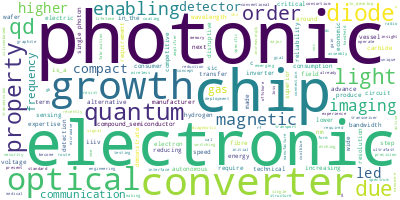

In [ ]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(str(v) for v in list(preprocessed_text))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

### Testing to find best parameters

The following code block is a series of tests to find the best number of topics, and number of times to run the program so that the model is the most optimal. In addition it also finds the best alpha and beta value (small parameters to understand the distribution of words and topics within the model).

In [ ]:
## NUMBER OF TOPICS AND PASSES
# ↓ ↓ ↓ ↓ ↓ Define the range of topics and passes to try, CHANGE NUMBERS HERE IF YOU WANT TO TEST FOR OTHER VALUES
# ↓ ↓ ↓ ↓ ↓ formatting for this goes --> list(range(starting number, end number + 1, intervals (optional)))
topics_range = list(range(2, 11))  # Try 2 to 10 topics
passes_range = list(range(5, 16, 5))  # Try 5, 10, 15 passes

# Initialize variables to store the best coherence score and corresponding hyperparameters
best_coherence_score = -1
best_num_topics = None
best_passes = None

# Loop over different numbers of topics and passes to find the optimal hyperparameters
for num_topics in topics_range:
    for passes in passes_range:
        # Train the LDA model using LdaMulticore
        lda_model = gensim.models.LdaModel(corpus, num_topics=num_topics, id2word=id2word, passes=passes, random_state=42)

        # Calculate coherence score using c_v coherence measure (you can try other measures as well)
        coherence_model = CoherenceModel(model=lda_model, texts=df['preprocessed_text'], dictionary=id2word, coherence='c_v')
        coherence_score = coherence_model.get_coherence()

        # Print the results (optional)
        # ↓ ↓ ↓ ↓ ↓ If you want to print out the results of each test, remove the # sign before the line below
        print(f"Num Topics: {num_topics}, Passes: {passes}, Coherence Score: {coherence_score}")

        # Update the best coherence score and hyperparameters
        if coherence_score > best_coherence_score:
            best_coherence_score = coherence_score
            best_num_topics = num_topics
            best_passes = passes

print(f"Best Number of Topics: {best_num_topics}, Best Number Passes: {best_passes}, Final Coherence Score: {best_coherence_score}")

## ALPHA AND BETA PARAMETERS

# Define the range of alpha and eta values to try
alpha_values = [0.01, 0.1, 1.0, 'symmetric', 'asymmetric']
eta_values = [0.01, 0.1, 1.0, 'auto']

# Initialize variables to store the best coherence score and corresponding hyperparameters
best_coherence_score = -1
best_alpha = None
best_eta = None

# Loop over different alpha and eta values to find the optimal hyperparameters
for alpha in alpha_values:
    for eta in eta_values:
        # Train the LDA model with the current alpha and eta values
        lda_model = gensim.models.LdaModel(corpus, num_topics=best_num_topics, id2word=id2word, passes=best_passes, alpha=alpha, eta=eta, random_state=42)

        # Calculate coherence score using c_v coherence measure (you can try other measures as well)
        coherence_model = CoherenceModel(model=lda_model, texts=df['preprocessed_text'], dictionary=id2word, coherence='c_v')
        coherence_score = coherence_model.get_coherence()

        # Print the results (optional)
        # ↓ ↓ ↓ ↓ ↓ If you want to print out the results of each test, remove the # sign before the line below
        print(f"Alpha: {alpha}, Eta: {eta}, Coherence Score: {coherence_score}")

        # Update the best coherence score and hyperparameters
        if coherence_score > best_coherence_score:
            best_coherence_score = coherence_score
            best_alpha = alpha
            best_eta = eta

# Print the best hyperparameters
print(f"Best Alpha: {best_alpha}, Best Eta: {best_eta}, Final Coherence Score: {best_coherence_score}")

lda_model = gensim.models.LdaMulticore(corpus, num_topics=best_num_topics, id2word=id2word, passes=best_passes, alpha=best_alpha, eta=best_eta, random_state=42)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Num Topics: 2, Passes: 5, Coherence Score: 0.4225795287219345
Num Topics: 2, Passes: 10, Coherence Score: 0.4463564739341428
Num Topics: 2, Passes: 15, Coherence Score: 0.41905218537479727
Num Topics: 3, Passes: 5, Coherence Score: 0.4290543671559748
Num Topics: 3, Passes: 10, Coherence Score: 0.44135701056587306
Num Topics: 3, Passes: 15, Coherence Score: 0.45678057959630297
Num Topics: 4, Passes: 5, Coherence Score: 0.44066649076892633
Num Topics: 4, Passes: 10, Coherence Score: 0.43721307190974484
Num Topics: 4, Passes: 15, Coherence Score: 0.4332295276787232
Num Topics: 5, Passes: 5, Coherence Score: 0.4562264791936996
Num Topics: 5, Passes: 10, Coherence Score: 0.4650365710978723




---



If you don't need to run the training and already have a designated value for each parameter, just erase the # at the start of the line below and manually insert the values. Run this cell and you will have your final mode (if you already have the designated parameters, this will save you a lot of time).

In [ ]:
# if you want to make alpha or eta equal to 'symmetric', 'auto', or 'asymmetric' you must include quotes
# ie. gensim.models.LdaMulticore(corpus, num_topics=3, id2word=id2word, passes=15, alpha='symmetric', eta='auto', random_state=42)
# <- a number sign (#) in front of the code means the code will NOT run

# ↓ ↓ ↓ ↓ ↓ input your own values to test here, remember to remove the number sing before you run (#)
# lda_model = gensim.models.LdaMulticore(corpus, num_topics=3, id2word=id2word, passes=15, alpha=1.0, eta=1.0, random_state=42)

In [ ]:
lda_model = gensim.models.LdaMulticore(corpus, num_topics=best_num_topics, id2word=id2word, passes=best_passes, alpha=best_alpha, eta=best_eta, random_state=42)

### Visualizations

In [ ]:
import pyLDAvis.gensim
import pickle
import pyLDAvis
import os

# Visualize the topics
pyLDAvis.enable_notebook()
num_topics = 4
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
   # ↓ ↓ ↓ ↓ ↓ change the value in the parentheses () to view a new model, ie pyLDAvis.gensim.prepare(NEW_NAME, corpus, id2word)
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open('LDAvis_data_filepath', 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open('LDAvis_data_filepath', 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.display(LDAvis_prepared)

**The next two code chunks can just be run without being opened -- run all blocks by just clicking the (►) button in order to get the Excel and HTML output from tier2022 folder**

### Exporting Data to Excel

The following blocks just export all the results into an excel file which will appear in tier2022 folder on the lefthand side.

In [ ]:
# Assign topics, probabilities, and top keywords back to the DataFrame
def get_topic_and_probability(doc):
    topic_probs = lda_model.get_document_topics(doc, minimum_probability=0)
    return max(topic_probs, key=lambda x: x[1])

def get_top_keywords_for_topic(topic_num, topn=5):
    return [lda_model.id2word[word_id] for word_id, _ in lda_model.get_topic_terms(topic_num, topn=topn)]

df['topic'], df['relevancyToTopic'] = zip(*df['preprocessed_text'].apply(lambda doc: get_topic_and_probability(id2word.doc2bow(doc))))
df['topKeywords'] = df['topic'].apply(lambda topic_num: get_top_keywords_for_topic(topic_num))

# add organization data
orgs = pd.read_excel('/content/tier2022/keywordResults.xlsx', sheet_name='organizations')
orgs['name'] = orgs['name'].str.replace('"', '')
# orgs['shortName'] = orgs['shortName'].str.replace('"', '')
orgs = orgs.rename(columns={'projectID':'id'})
temp = orgs.pivot_table(index='id', columns='role', values='name', aggfunc=list).reset_index().merge(orgs[['country', 'id']], on='id', how='left')
temp = temp.drop_duplicates(subset=['id'])
df = df.merge(temp, on='id', how='left')
df['topic'] = df['topic'] + 1
df['coordinator'] = df['coordinator'].astype(str).replace(r'[\[\]\'\']', '', regex=True).str.title()
df['participant'] = df['participant'].astype(str).replace(r'[\[\]\'\']', '', regex=True).str.title()
final = df.drop(columns=['preprocessed_text', 'text'])

In [ ]:
# count number of countries per topic
# df['topic'] = df['topic'].apply(tuple)
country = df.groupby('topic')['country'].value_counts().reset_index(name='countryCount')
country = country.groupby('topic').apply(lambda x: x.sort_values('countryCount', ascending=False)).reset_index(drop=True)
df['topKeywords'] = df['topKeywords'].apply(tuple)
country = country.merge(df[['topKeywords','topic']].drop_duplicates(['topKeywords','topic']), on='topic', how='inner')
country = country.merge(df.groupby(['topic', 'country'])['totalCost'].sum().reset_index(name='totalFundingPerCountry'), on=['topic', 'country'], how='left')

temp = df.drop_duplicates('title')
# most money per topic
df['totalCost'] = pd.to_numeric(df['totalCost'], errors='coerce')
money = temp.groupby('topic').apply(lambda x: x.sort_values('totalCost', ascending=False)).reset_index(drop=True)
money = money[['topic', 'topKeywords', 'id', 'title', 'objective', 'totalCost', 'coordinator', 'relevancyToTopic']]
topMoney = money.groupby('topic').apply(lambda x: x.nlargest(5, 'totalCost')).reset_index(drop=True)
money.set_index(pd.MultiIndex.from_frame(money[['topic', 'topKeywords']]), inplace=True)
money.drop(columns=['topic', 'topKeywords'], inplace=True)
topMoney.set_index(pd.MultiIndex.from_frame(topMoney[['topic', 'topKeywords']]), inplace=True)
topMoney.drop(columns=['topic', 'topKeywords'], inplace=True)

# most relevant projects per topic
relevancy = temp.groupby('topic').apply(lambda x: x.sort_values('relevancyToTopic', ascending=False)).reset_index(drop=True)
relevancy = relevancy[['topic', 'topKeywords', 'id', 'title', 'objective', 'totalCost', 'coordinator', 'relevancyToTopic']]
topRelevancy = relevancy.groupby('topic').apply(lambda x: x.nlargest(5, 'relevancyToTopic')).reset_index(drop=True)
relevancy.set_index(pd.MultiIndex.from_frame(relevancy[['topic', 'topKeywords']]), drop=True, inplace=True)
relevancy.drop(columns=['topic', 'topKeywords'], inplace=True)
topRelevancy.set_index(pd.MultiIndex.from_frame(topRelevancy[['topic', 'topKeywords']]), drop=True, inplace=True)
topRelevancy.drop(columns=['topic', 'topKeywords'], inplace=True)

# number projects coordinated per organization
project_counts = df.groupby('coordinator')['id'].nunique().reset_index(name='Projects Coordinated (total)')
project_counts = project_counts.sort_values(by='Projects Coordinated (total)', ascending=False)

# Group by 'coordinator' and 'Topic' to calculate the number of projects coordinated per topic
project_counts_topic = df.groupby(['coordinator', 'topic'])['id'].nunique().reset_index(name='projectsCoordinatedPerTopic')

# Initialize topic counts dictionary with 0 counts for all topics
unique_topics = df['topic'].unique()
topic_counts_dict = {"Topic " + str(i + 1): 0 for i, topic in enumerate(unique_topics)}

# Create a dictionary for each coordinator containing topic and project count
coordinator_topic_counts_dict = {}
for index, row in project_counts_topic.iterrows():
    coordinator = row['coordinator'].strip('"')
    topic = row['topic']
    count = row['projectsCoordinatedPerTopic']
    if coordinator not in coordinator_topic_counts_dict:
        coordinator_topic_counts_dict[coordinator] = topic_counts_dict.copy()
    coordinator_topic_counts_dict[coordinator][f"Topic {topic + 1}"] = count
project_counts['coordinator'] = project_counts['coordinator'].str.strip('"')
project_counts['Projects Coordinated (by topic)'] = project_counts['coordinator'].apply(lambda x: coordinator_topic_counts_dict[x])
project_counts= project_counts.drop_duplicates('coordinator')

# -------------------------------------------------------------------------------

# format dataframes for html report
def reformat_projects(df):
  df = df.rename(columns={'id':'Project ID', 'objective':'Project Description', 'title':'Title', 'coordinator':'Coordinator', 'topic':'Topic','country':'Country','countryCount':'Count','topKeywords':'Keywords','totalCost':'Funding (Euro)','relevancyToTopic':'Relevancy Score', 'totalFundingPerCountry':'Funding (Euro)'})
  if 'Funding (Euro)' in df.columns:
    df['Funding (Euro)'] = df['Funding (Euro)'].astype(float).apply(lambda x: f"{x:,.0f}")
  if 'Project ID' in df.columns:
    if len(df['Project ID'].astype(str)) < 9:
      df['Project ID'] = df['Project ID'].apply(lambda x: f'<a href="https://gtr.ukri.org/projects?ref={x}">{x}</a>')
    else:
      df['Project ID'] = df['Project ID'].apply(lambda x: f'<a href="https://cordis.europa.eu/project/id/{x}">{x}</a>')
  return df

topRelevanceProjects = reformat_projects(topRelevancy.reset_index())
topRelevanceProjects.drop(columns='Project Description', inplace=True)
topRelevanceProjects.set_index(['Keywords','Topic'], inplace=True)
topRelevanceProjects.groupby('Keywords', group_keys=False).apply(lambda x: x.sort_values('Funding (Euro)', ascending=False))
topCostProjects = reformat_projects(topMoney.reset_index())
topCostProjects.drop(columns='Project Description', inplace=True)
topCostProjects.set_index(['Keywords','Topic'], inplace=True)
topCostProjects = topCostProjects.groupby('Keywords', group_keys=False).apply(lambda x: x.sort_values('Funding (Euro)', ascending=True))
topCountryProjects = reformat_projects(country).groupby('Topic').apply(lambda x: x.nlargest(5, 'Count')).drop(columns=['Topic']).reset_index()
topCountryProjects.set_index(['Keywords','Topic'], inplace=True)
topCountryFunding = country.groupby('topic').apply(lambda x: x.nlargest(5, 'totalFundingPerCountry')).drop(columns=['topic']).reset_index()
topCountryFunding.drop(columns='level_1', inplace=True)
topCountryFunding = reformat_projects(topCountryFunding)
topCountryFunding.set_index(['Keywords','Topic'], inplace=True, drop=True)
project_counts = reformat_projects(project_counts)

In [ ]:
with pd.ExcelWriter("topicModelingResults.xlsx", engine='xlsxwriter') as writer:
  final.to_excel(writer, sheet_name="projects", index=False, float_format="%f")
  country.to_excel(writer, sheet_name="topicByTopCountry", index=False, float_format="%f")
  money.to_excel(writer, sheet_name="projectsByTopFunding", index=True, float_format="%f")
  relevancy.to_excel(writer, sheet_name="projectsByTopRelevancy", index=True, float_format="%f")
  project_counts.to_excel(writer, sheet_name='nProjects', index=True, float_format="%f")

### Generating HTML Output

**Making Visualizations**

In [ ]:
%%capture

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

px.defaults.template = "seaborn"

project_funding_per_topic = df.groupby(['topic', 'topKeywords'])['totalCost'].sum().reset_index(name='Funding (Euro)')
project_count_per_topic = df.groupby(['topic','topKeywords'])['id'].count().reset_index(name='Count')
tt = project_funding_per_topic.merge(project_count_per_topic, how='outer', on=['topic', 'topKeywords'])
tt['topKeywords'] = tt['topKeywords'].apply(lambda x: ', '.join(str(item) for item in x))

# Create the initial figure
initial_y_axis = 'Count'

# Create the dropdown options
dropdown_options = [
    {'label': 'Count', 'value': 'Count'},
    {'label': 'Funding (Euro)', 'value': 'Funding (Euro)'}
]
# Create the initial figure with subplots
frequency = make_subplots(rows=1, cols=1)

# Add a bar trace to the figure with text labels
bar_trace = go.Bar(
    x=tt['topic'],
    y=tt[initial_y_axis],
    text=tt['topKeywords'],  # Use 'topKeywords' as text labels
    textposition='auto',     # Display labels above the bars
    textfont=dict(color="white"),
    marker=dict(color="white")
)
frequency.add_trace(bar_trace)


# Create the dropdown settings
dropdown_settings = [
    {
        'method': 'update',
        'label': option['label'],
        'args': [
            {'y': [tt[option['value']]]},
            {'yaxis': {'title': option['label']}},
            {'title': 'Distribution of Topics based on'}
        ]
    }
    for option in dropdown_options
]

# Update the layout with dropdown buttons
frequency.update_layout(
    updatemenus=[
        {
            'buttons': dropdown_settings,
            'pad':{"r": 10, "t": 10},
            'direction': 'down',
            'showactive': True,
            'x': 0.2,
            'xanchor': 'left',
            'y': 1.15,
            'yanchor': 'top'
        }
    ]
)

# Set the initial y-axis data, label, and title
initial_option = dropdown_options[0]
frequency.update_yaxes(title_text=initial_option['label'])
frequency.update_xaxes(title_text='Topic')
frequency.update_layout(title_text=f'Distribution of Topics based on {initial_option["label"]}')

# Update the trace marker color
frequency.update_traces(marker=dict(color="cornflowerblue"))

In [ ]:
%%capture

min_percentage_threshold = 1
topic_figures = {}

rows = (len(country['topic'].unique()) + 2) // 3  # dynamically updates
cols = min(len(country['topic'].unique()), 3)
pies = make_subplots(rows=rows, cols=cols, specs =[[{"type": "pie"}] * cols for _ in range(rows)], subplot_titles=country['topic'].astype(str).unique())

row_num = 1
col_num = 1

for topic in country['topic'].unique()-1:
    topic_data = country[country['topic'] == topic]
    total_funding = topic_data['totalFundingPerCountry'].sum()
    topic_data['Percentage'] = (topic_data['totalFundingPerCountry'] / total_funding) * 100
    filtered_data = topic_data[topic_data['Percentage'] >= min_percentage_threshold]
    keywords = ', '.join(topic_data.iloc[0]['topKeywords'])

    pie_trace = go.Pie(
        labels=filtered_data['country'],
        values=filtered_data['totalFundingPerCountry'],
        title=f"Keywords: {keywords}",
        title_position='top center',
        hole=0.3,
        hoverinfo="label+percent+name"
    )
    pies.add_trace(pie_trace, row=row_num, col=col_num)
    pies.update_traces(
        textposition='auto',
        hoverinfo="label+percent+name+value",
        textinfo='label+percent'
    )

    col_num += 1
    if col_num > cols:
        col_num = 1
        row_num += 1

pies.update_layout(
    title="Share of Country Funding per Topic",
    showlegend=True,
    height=750 * rows, width=1700 # add height and width multiplied by number of rows and columns
)

In [ ]:
# Creates html report
page_title = "Topic Modeling Report"
pyldavis_html = pyLDAvis.prepared_data_to_html(LDAvis_prepared)

# Define the custom HTML template
custom_template = f'''
  <html>
    <head>
        <title>{page_title}</title>
        <link rel="stylesheet" href="reportStyle.css" type="text/css" media="all">
        <meta charset="UTF-8">
        <script src="https://cdn.plot.ly/plotly-2.12.1.min.js"></script>
        <style>
            .center-div {{
                text-align: center;
            }}
        </style>
    </head>
    <body>
      <div id="title">
        <h1>{title_text}</h1>
          <p>{text}</p>
      </div>
      <div id="pyLDAvis Visualization">
        <h2>{'Results of Topic Modeling'}</h2>
        {pyldavis_html}
      </div>
      <div id="topRelevance">
        <h2>{'Most relevant projects by similarity score'}</h2>
          <p>{'These projects had the highest similarity score per topic'}</p>
          {topRelevanceProjects.to_html(index=True, escape=False, justify="center", classes='table', table_id="topProjects")}
      </div>
      <div id="topCost">
        <h2>{'Most costly projects'}</h2>
          <p>{'These are the five most funded projects per topic'}</p>
          {topCostProjects.to_html(index=True, escape=False, justify="center", classes='table', table_id="topCosts")}
      </div>
      <div class="center-div">
          {frequency.to_html(full_html=False, include_plotlyjs=False, default_width='75%', default_height='75%', div_id='costProjGraph')}
      </div>
      <div style="display: flex;" id="topCountries">
        <div style="flex: 50%; padding-right: 10px;">
          <h2>{'Top countries leading projects in each topic'}</h2>
            <p>{'These countries have the most projects in each topic'}</p>
            {topCountryProjects.to_html(index=True, escape=False, justify="center", classes='table', table_id="topProjects")}
        </div>
        <div style="flex: 50%; padding-left: 10px;">
          <h2>{'Top funded countries in each topic'}</h2>
            <p>{'These countries have the most funding in each topic'}</p>
            {topCountryFunding.to_html(index=True, escape=False, justify="center", classes='table', table_id="topCountryFunding")}
        </div>
      </div>
      <div class="center-div">
          {pies.to_html(full_html=False, include_plotlyjs=False, default_width='75%', default_height='75%', div_id='costCountryGraph')}
      </div>
      <div id="coordinatorCounts" >
        <h2>{"Lead coordinators"}</h2>
          <p>{"These coordinators are leading the most projects"}</p>
          {project_counts.head().to_html(index=True, escape=False, justify="center", classes='table', table_id="topCosts")}
      </div>
    </body>
  </html>
'''

with open('topicModelingGraphs.html', 'w') as f:
    f.write(custom_template)